## OpenCV Integration Example
Note: SwiftCV package requires OpenCV installed in order to compile.

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SwiftCV")' SwiftCV
%install '.package(path: "$cwd/FastaiNotebook_08_data_block")' FastaiNotebook_08_data_block

Installing packages:
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/FastaiNotebook_08_data_block")
		FastaiNotebook_08_data_block
With SwiftPM flags: []
Working in: /tmp/tmpc0jnycnz/swift-install
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
Updating https://github.com/latenitesoft/NotebookExport
Updating https://github.com/mxcl/Path.swift
Updating https://github.com/JustHTTP/Just
Completed resolution in 4.85s
Compile COpenCV core.cpp
Compile COpenCV imgproc.cpp
Compile COpenCV imgcodecs.cpp
Compile COpenCV version.cpp
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/

### Imports

In [ ]:
%include "EnableIPythonDisplay.swift"
import Foundation
import Python
import TensorFlow
import SwiftCV
import Path

let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
import FastaiNotebook_08_data_block

In [ ]:
// display opencv version
print(cvVersion())

4.1.0


In [ ]:
func show_img(_ img: Mat, _ w: Int = 7, _ h: Int = 5) {
    show_img(Tensor<UInt8>(cvMat: img)!, w, h)
}

### Load image

In [ ]:
func readImage(_ path:String)->Mat {
    let cvImg = imread(path)
    return cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)
}

In [ ]:
let path = downloadImagenette(sz:"")
let allNames = fetchFiles(path: path/"train/n03425413", recurse: false, extensions: ["jpeg", "jpg"])
let fNames = Array(allNames[0..<256])
let ns = fNames.map {$0.string}
let imgpath = ns[2]
var cvImg = readImage(imgpath)

### Timing

In [ ]:
cvImg.size

▿ 2 elements
  - 0 : 400
  - 1 : 500


In [ ]:
print(type(of:cvImg.dataPtr))

UnsafeMutablePointer<Int8>


In [ ]:
let ptr = UnsafeBufferPointer<UInt8>(start: UnsafePointer<UInt8>(cvImg.dataPtr), count: cvImg.count)

In [ ]:
time(repeating:10) {_ = readImage(imgpath)}

average: 4.0099855 ms,   min: 3.595419 ms,   max: 4.960401 ms


In [ ]:
cvImg.rows

400


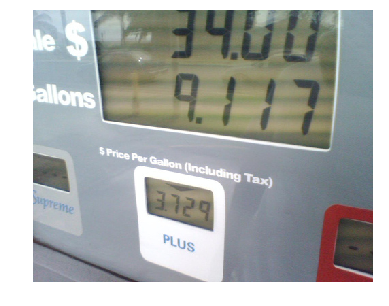

In [ ]:
show_img(cvImg)

In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_NEAREST)}

average: 0.12099200000000003 ms,   min: 0.119302 ms,   max: 0.122965 ms


In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_LINEAR)}

average: 0.6822158 ms,   min: 0.677596 ms,   max: 0.699217 ms


In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_CUBIC)}

average: 0.6327788000000001 ms,   min: 0.630617 ms,   max: 0.639883 ms


In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_AREA)}

average: 2.1974129000000007 ms,   min: 2.187303 ms,   max: 2.212594 ms


In [ ]:
cvImg = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_CUBIC)

In [ ]:
func readResized(_ fn:String)->Mat {
    return resize(readImage(fn), nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_CUBIC)
}

In [ ]:
var imgs = ns[0..<10].map(readResized)

In [ ]:
time(repeating:10) {_ = readResized(imgpath)}

average: 4.240055400000001 ms,   min: 4.210664 ms,   max: 4.275787 ms


In [ ]:
public protocol Countable {
    var count:Int {get}
}
extension Mat  :Countable {}
extension Array:Countable {}

public extension Sequence where Element:Countable {
    var totalCount:Int { return map({ $0.count }).reduce(0, +) }
}

In [ ]:
func collateMats(_ imgs:[Mat])->Tensor<Float> {
    let c = imgs.totalCount
    let ptr = UnsafeMutableRawPointer.allocate(byteCount: c, alignment: 1)
    defer {ptr.deallocate()}
    var p = ptr
    for img in imgs {
        p.copyMemory(from: img.dataPtr, byteCount: img.count)
        p = p.advanced(by: img.count)
    }
    let r = UnsafeBufferPointer(start: ptr.bindMemory(to: UInt8.self, capacity: c), count: c)
    cvImg = imgs[0]
    let shape = TensorShape([imgs.count, cvImg.rows, cvImg.cols, cvImg.channels])
    let res = Tensor(shape: shape, scalars: r)
    return Tensor<Float>(res)/255.0
}

In [ ]:
var t = collateMats(imgs)

In [ ]:
t.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 10
    - 1 : 224
    - 2 : 224
    - 3 : 3


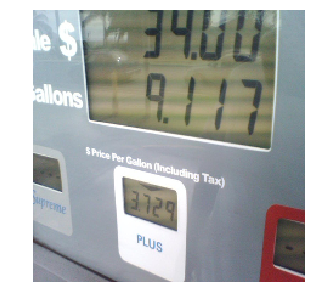

In [ ]:
show_img(t[2])

In [ ]:
time(repeating:10) {_ = collateMats(imgs)}

average: 1.155548 ms,   min: 1.08063 ms,   max: 1.355952 ms


In [ ]:
time { _ = ns.map(readResized) }

average: 1894.758874 ms,   min: 1894.758874 ms,   max: 1894.758874 ms


### OpenCV Transformations

#### Resize

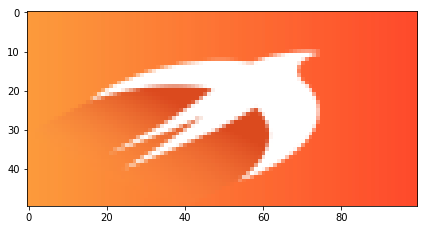

In [ ]:
show_img(
    resize(cvImg, nil, Size(100, 50), 0, 0, InterpolationFlag.INTER_AREA)
)

#### Zoom / Crop

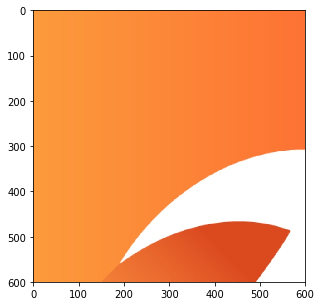

In [ ]:
let zoomMat = getRotationMatrix2D(Size(cvImg.cols, cvImg.rows / 2), 0, 1)
show_img(
    warpAffine(cvImg, nil, zoomMat, Size(600, 600))
)

#### Rotate

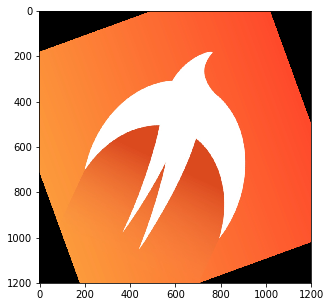

In [ ]:
let rotMat = getRotationMatrix2D(Size(cvImg.cols / 2, cvImg.rows / 2), 20, 1)
show_img(
    warpAffine(cvImg, nil, rotMat, Size(cvImg.cols, cvImg.rows))
)

#### Pad

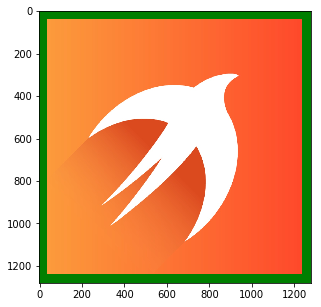

In [ ]:
show_img(
    copyMakeBorder(cvImg, nil, 40, 40, 40, 40, BorderType.BORDER_CONSTANT, RGBA(0, 127, 0, 0))
)

#### Blur

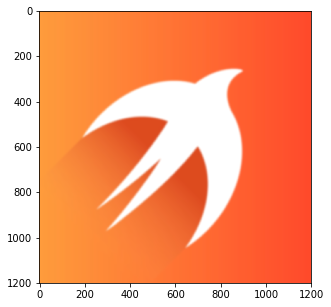

In [ ]:
show_img(
    GaussianBlur(cvImg, nil, Size(25, 25))
)

#### Flip

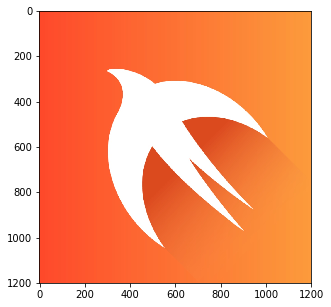

In [ ]:
show_img(
    flip(cvImg, nil, FlipMode.HORIZONTAL)
)

#### Transpose

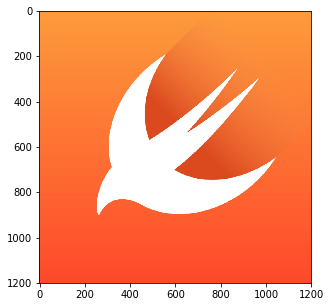

In [ ]:
show_img(
    transpose(cvImg, nil)
)